In [ ]:
!kubectl get no -o json > /common/workdir/instance.types.kube.json
!aws ec2 describe-instance-types --region us-east-1 > /common/workdir/instance.types.aws.json

%pip install urllib3==1.25.9 \
             pandas==1.3.5 \
             matplotlib==3.5.1 \
             tables==3.7.0

In [71]:
import os
import json
import logging

import pandas as pd
import numpy as np

In [72]:
logging.basicConfig(level='INFO', format='%(asctime)s:%(levelname)s: %(message)s')

In [73]:
workdir = '/common/workdir'

In [74]:
with open(os.path.join(workdir, 'instance.types.aws.json')) as f:
    instance_types_aws_json = json.load(f)

In [75]:
with open(os.path.join(workdir, 'instance.types.kube.json')) as f:
    instance_types_kube_json = json.load(f)

In [76]:
def extract_from_instance_types_aws_json(instance_types_json):
    for instance_type_json in instance_types_json.get('InstanceTypes', []):
        instance_type_name = instance_type_json.get('InstanceType', '')
        instance_type_cpu = instance_type_json.get('VCpuInfo', {}).get('DefaultVCpus', 0)
        instance_type_mem_mib = instance_type_json.get('MemoryInfo', {}).get('SizeInMiB', 0)
        instance_type_mem_kib = instance_type_mem_mib * 1024
        if not instance_type_name or not instance_type_cpu or not instance_type_mem_kib:
            continue
        yield [instance_type_name, instance_type_cpu, instance_type_mem_kib]

instance_types_aws_df = pd.DataFrame(extract_from_instance_types_aws_json(instance_types_aws_json),
                                     columns=['name', 'cpu', 'mem, kib'])
instance_types_aws_df = instance_types_aws_df.groupby(['name']) \
                                             .agg({'cpu': np.min, 'mem, kib': np.min})
instance_types_aws_df.sort_index(inplace=True)
instance_types_aws_df

,cpu,"mem, kib"
name,,
a1.2xlarge,8,16777216
a1.4xlarge,16,33554432
a1.large,2,4194304
a1.medium,1,2097152
a1.metal,16,33554432
...,...,...
z1d.3xlarge,12,100663296
z1d.6xlarge,24,201326592
z1d.large,2,16777216


In [77]:
def extract_from_instance_types_kube_json(instance_types_json):
    for instance_type_json in instance_types_json.get('items', []):
        instance_type_name = instance_type_json.get('metadata', {}).get('labels', {}).get('cloud_ins_type', '')
        instance_type_cpu = instance_type_json.get('status', {}).get('capacity', {}).get('cpu', 0)
        instance_type_mem_kib = instance_type_json.get('status', {}).get('capacity', {}).get('memory', '0Ki')
        if not instance_type_mem_kib or not instance_type_mem_kib.endswith('Ki'):
            logging.warning('Instance type {} memory capacity is invalid: {}'
                            .format(instance_type_name,
                                    instance_type_mem_kib))
            continue
        instance_type_mem_kib = int(instance_type_mem_kib.replace('Ki', ''))
        if not instance_type_name or not instance_type_cpu or not instance_type_mem_kib:
            continue
        yield [instance_type_name, instance_type_cpu, instance_type_mem_kib]

instance_types_kube_df = pd.DataFrame(extract_from_instance_types_kube_json(instance_types_kube_json),
                                     columns=['name', 'cpu', 'mem, kib'])
instance_types_kube_df = instance_types_kube_df.groupby(['name']) \
                                               .agg({'cpu': np.min, 'mem, kib': np.min})
instance_types_kube_df.sort_index(inplace=True)
instance_types_kube_df

,cpu,"mem, kib"
name,,
c5.12xlarge,48,96799396
c5.2xlarge,8,15949400
c5.4xlarge,16,31889616
c5.9xlarge,36,72028908
c5.large,2,3793536
c5.xlarge,4,7807260
c6i.2xlarge,8,16150104
c6i.32xlarge,128,259967648
c6i.8xlarge,32,64916924


In [78]:
instance_types_df = instance_types_aws_df.join(instance_types_kube_df,
                                               lsuffix=', nominal',
                                               rsuffix=', actual')
instance_types_df.dropna(inplace=True)
instance_types_df.sort_index(inplace=True)
instance_types_df['mem, kib, actual'] = instance_types_df['mem, kib, actual'].astype(int)
instance_types_df['mem, kib, diff'] = instance_types_df['mem, kib, nominal'] - instance_types_df['mem, kib, actual']
instance_types_df['mem, %, diff'] = (instance_types_df['mem, kib, diff'] / instance_types_df['mem, kib, nominal']) * 100
instance_types_df['family'] = instance_types_df.index.map(lambda it: it.split('.', 1)[0])
instance_types_df

,"cpu, nominal","mem, kib, nominal","cpu, actual","mem, kib, actual","mem, kib, diff","mem, %, diff",family
name,,,,,,,
c5.12xlarge,48,100663296,48,96799396,3863900,3.838440,c5
c5.2xlarge,8,16777216,8,15949400,827816,4.934168,c5
c5.4xlarge,16,33554432,16,31889616,1664816,4.961538,c5
c5.9xlarge,36,75497472,36,72028908,3468564,4.594278,c5
c5.large,2,4194304,2,3793536,400768,9.555054,c5
c5.xlarge,4,8388608,4,7807260,581348,6.930208,c5
c6i.2xlarge,8,16777216,8,16150104,627112,3.737879,c6i
c6i.32xlarge,128,268435456,128,259967648,8467808,3.154504,c6i
c6i.8xlarge,32,67108864,32,64916924,2191940,3.266245,c6i


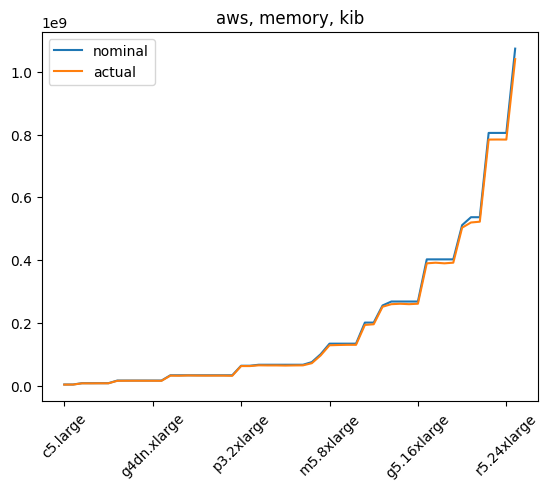

In [79]:
from matplotlib import pyplot as plt
instance_types_df.sort_values(by='mem, kib, nominal') \
                 .rename(columns={'mem, kib, nominal': 'nominal',
                                  'mem, kib, actual': 'actual'}) \
                 .plot(y=['nominal', 'actual'],
                       title='aws, memory, kib',
                       xlabel='', ylabel='',
                       rot=45)
plt.show()

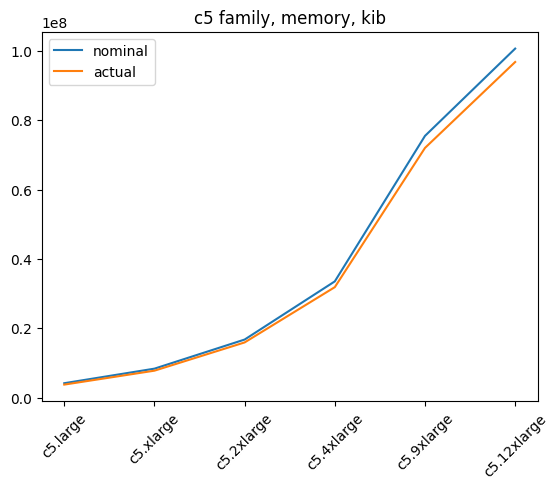

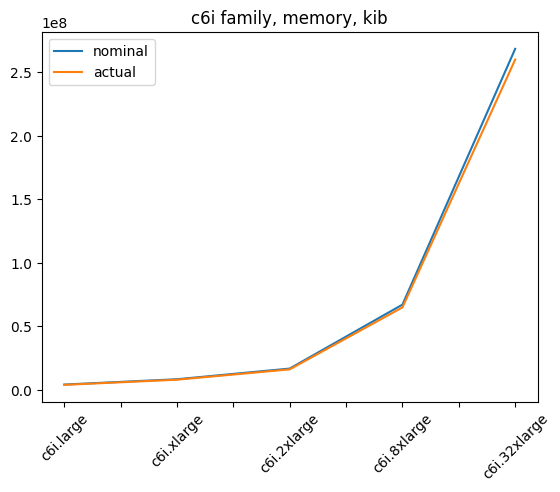

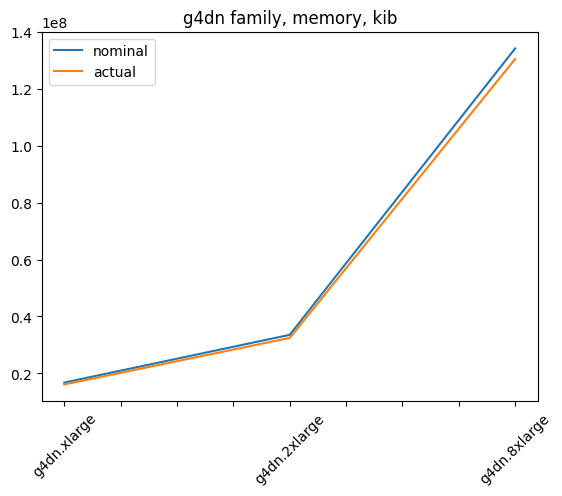

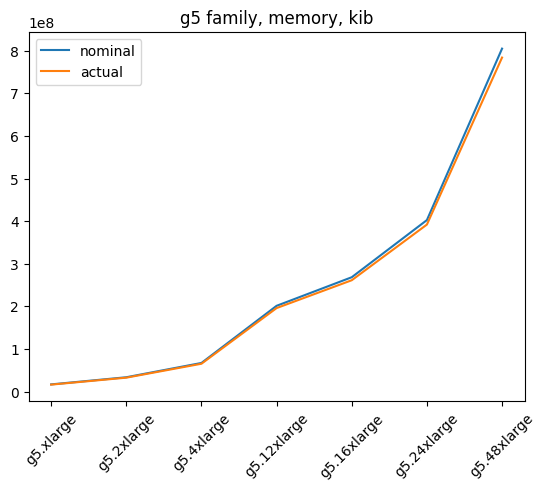

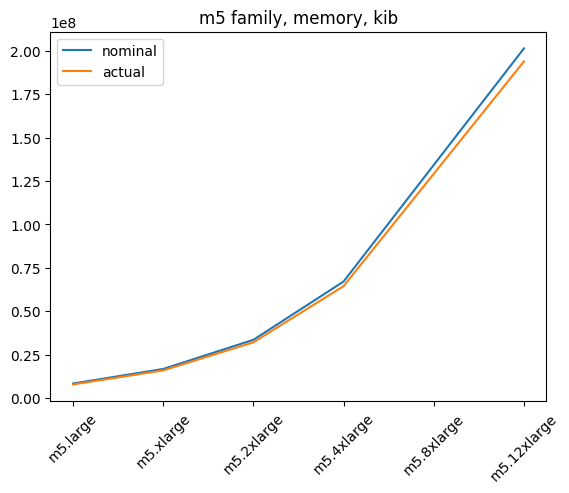

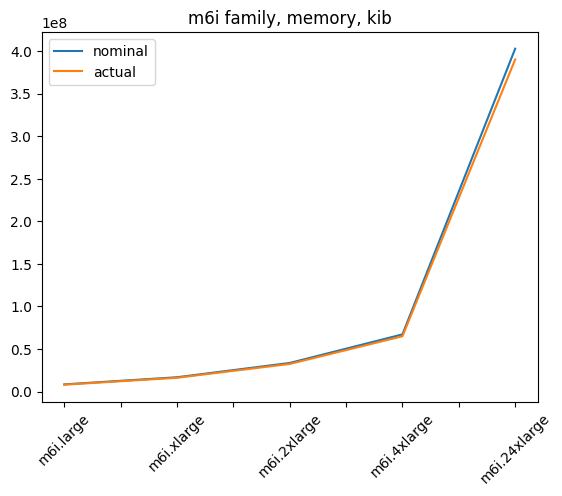

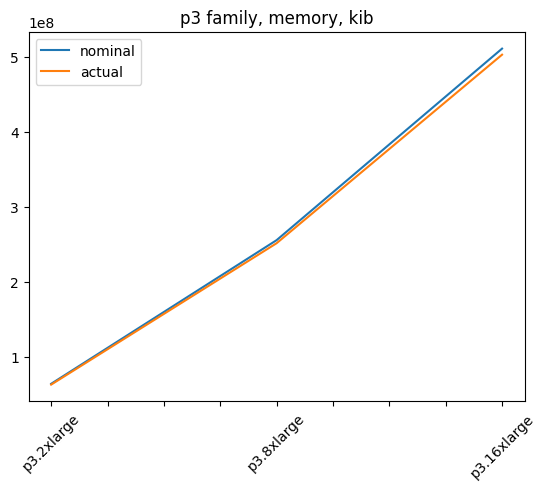

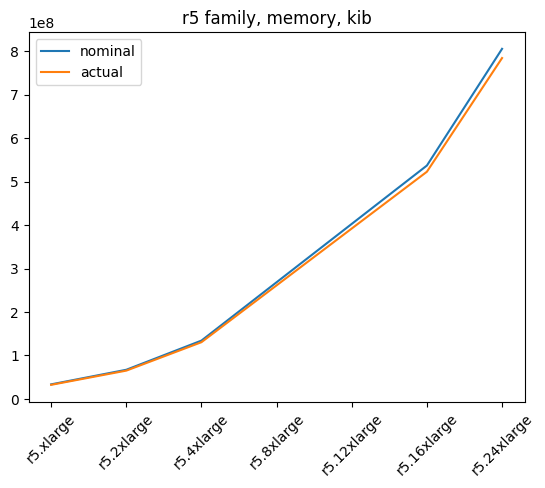

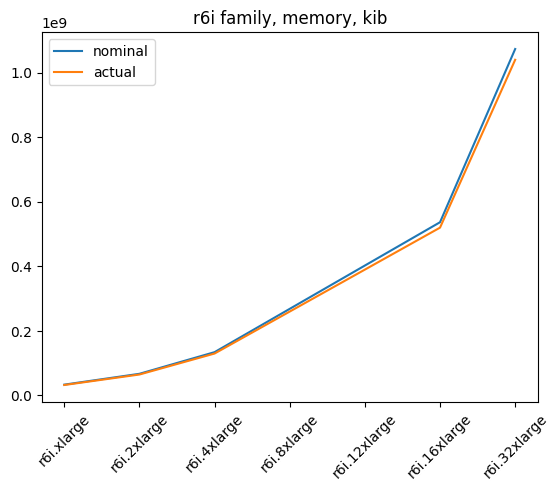

In [80]:
for instance_type_family, instance_types_family_df in instance_types_df.groupby('family'):
    if instance_types_family_df.shape[0] < 2:
        continue
    instance_types_family_df.sort_values(by='mem, kib, nominal') \
                            .rename(columns={'mem, kib, nominal': 'nominal',
                                             'mem, kib, actual': 'actual'}) \
                            .plot(y=['nominal', 'actual'],
                                  title='{} family, memory, kib'.format(instance_type_family),
                                  xlabel='', ylabel='',
                                  rot=45)
    plt.show()

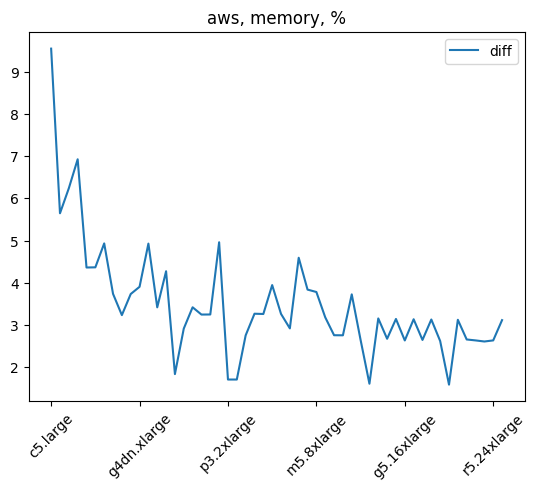

In [81]:
from matplotlib import pyplot as plt
instance_types_df.sort_values(by='mem, kib, nominal') \
                 .rename(columns={'mem, %, diff': 'diff'}) \
                 .plot(y=['diff'],
                       title='aws, memory, %',
                       xlabel='', ylabel='',
                       rot=45)
plt.show()

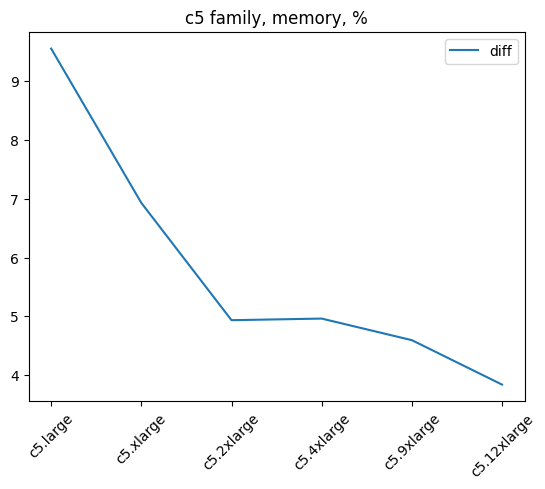

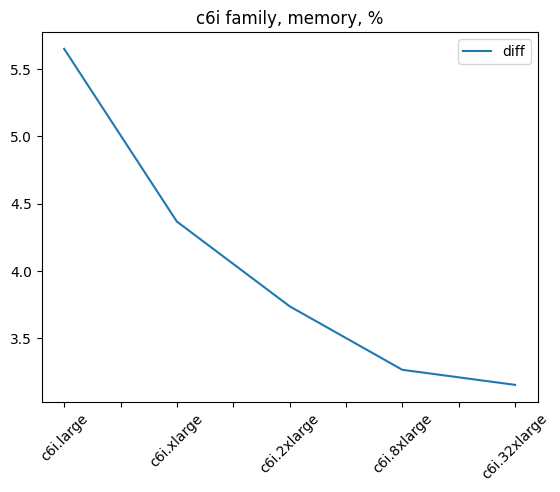

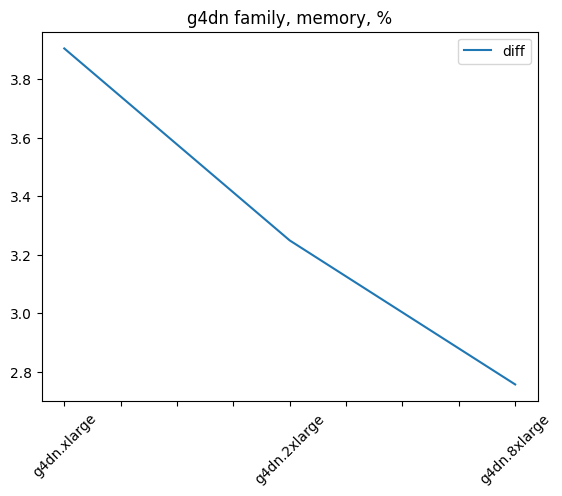

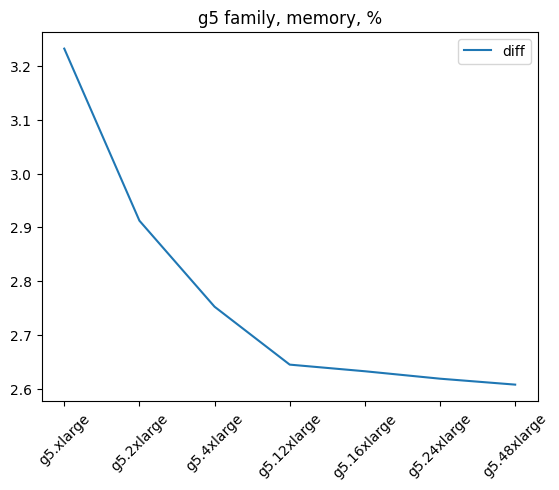

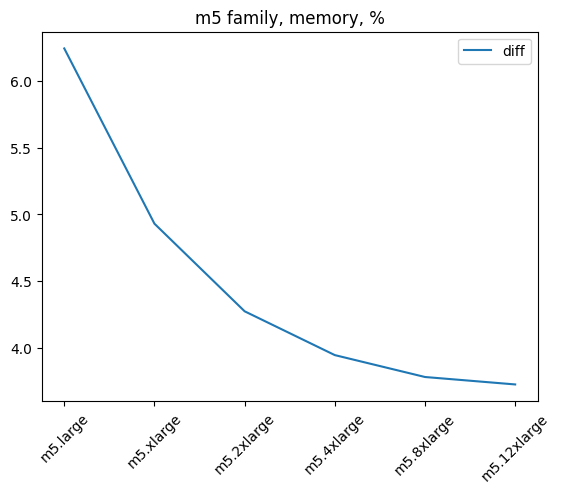

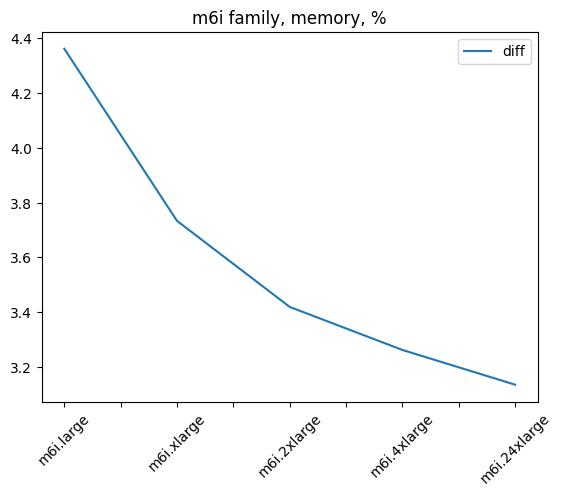

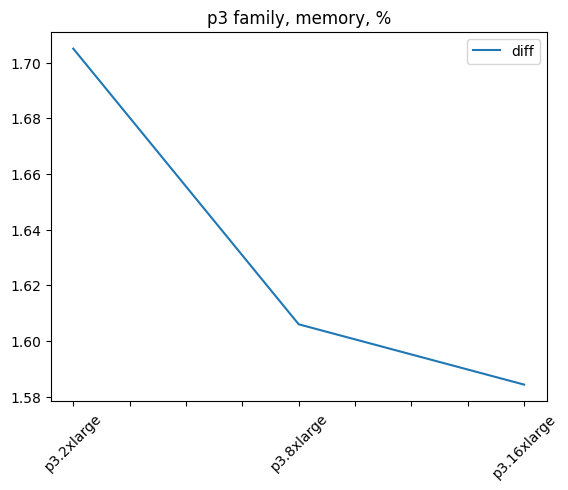

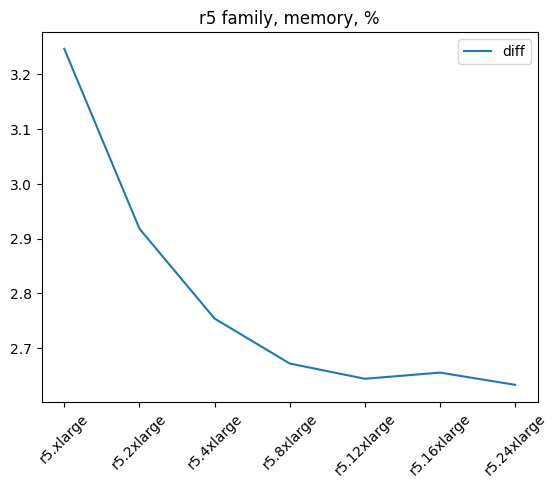

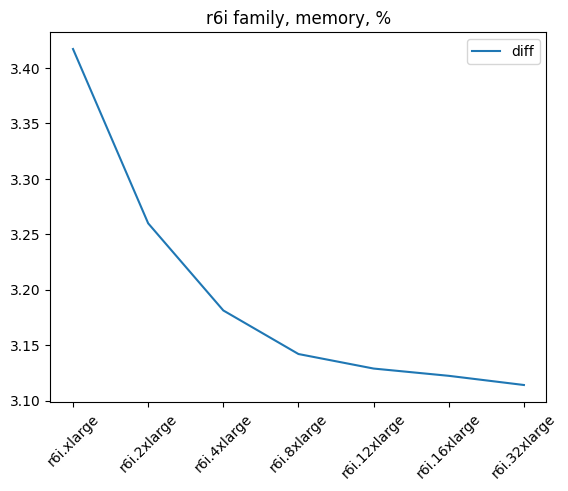

In [82]:
for instance_type_family, instance_types_family_df in instance_types_df.groupby('family'):
    if instance_types_family_df.shape[0] < 2:
        continue
    instance_types_family_df.sort_values(by='mem, kib, nominal') \
                            .rename(columns={'mem, %, diff': 'diff'}) \
                            .plot(y=['diff'],
                                  title='{} family, memory, %'.format(instance_type_family),
                                  xlabel='', ylabel='',
                                  rot=45)
    plt.show()